### Loading Data

In [2]:
# load some packages
import matplotlib.pyplot as plt
import healpy as hp
import numpy as np
import pandas as pd

from MMD_functions import *

# load the catalogue
catalogue1000 = np.load('catalogue_1000sqd.npy')

In [3]:
nside = 64 # HEALPix nside parameter

cl_kappa_225 = np.loadtxt('cl_kappa_mean_225.txt')[:,1]
cl_kappa_225 = np.concatenate((np.zeros(2), cl_kappa_225)) # add zeros for monopole and dipole
kappamap_225 = hp.synfast(cl_kappa_225, nside)
print("Cl_kappa225 shape:", cl_kappa_225.shape, "   kappamap225 shape:", kappamap_225.shape )

Cl_kappa225 shape: (10000,)    kappamap225 shape: (49152,)


In [4]:
pixscale = 0.263
sizes_in_arcsec1000 = catalogue1000['r50'] * pixscale   #arcsec

In [5]:
print( "\nrange of DEC of catalogue1000:")
print(f"[{min(catalogue1000['dec'])},{max(catalogue1000['dec'])}]" )
print( "\nrange of RA of catalogue1000:")
print(f"[{min(catalogue1000['ra'])},{max(catalogue1000['ra'])}]" )



range of DEC of catalogue1000:
[-17.89552116394043,17.89537239074707]

range of RA of catalogue1000:
[-17.928665161132812,17.927947998046875]


In [6]:
# Convert galaxy coordinates to HEALPix pixel indices
galaxy_pix1000= hp.ang2pix(nside, catalogue1000['ra'], catalogue1000['dec'], lonlat=True)
galaxy_pix1000_unique, galaxy_pix1000_counts = np.unique(galaxy_pix1000, return_counts=True)
n_pixels = hp.nside2npix(nside)

print("Galaxy pixels:",galaxy_pix1000, "   Length of Galaxy pixels(should match nr. of galaxies):", len(galaxy_pix1000))
print("Total number of galaxies:", len(catalogue1000))
print("Total number of pixels:", n_pixels)
print("Number of unique pixels with galaxies:", len(galaxy_pix1000_unique))
print("Max number of galaxies in a pixel:", np.max(galaxy_pix1000_counts))
print("Min number of galaxies in a pixel:", np.min(galaxy_pix1000_counts))
print("Mean number of galaxies in a pixel:", np.mean(galaxy_pix1000_counts))
print("Number of pixels with > 20'000 galaxies:", np.sum(galaxy_pix1000_counts >= 20000))
print('-'*30)

Galaxy pixels: [17024 17024 17024 ... 31872 31872 31872]    Length of Galaxy pixels(should match nr. of galaxies): 31574550
Total number of galaxies: 31574550
Total number of pixels: 49152
Number of unique pixels with galaxies: 1248
Max number of galaxies in a pixel: 28645
Min number of galaxies in a pixel: 1439
Mean number of galaxies in a pixel: 25300.12019230769
Number of pixels with > 20'000 galaxies: 1145
------------------------------


In [7]:
intrinsic_size1000 = sizes_in_arcsec1000
observed_size1000 = sizes_in_arcsec1000 * (1.0 + kappamap_225[galaxy_pix1000])

size_mask = (intrinsic_size1000 < 5.0) #arcsec


### Computing and Plotting the mean of each pixel
This is the most basic statistical measure, so we want to see, if we get a clear signal here.

Thresholds/Constraints from Noah's report:
- 20'000 galaxies per pixel for nside=64
- nside=64: In this case, the avg number of galaxies is above the needed threshold
- Outliers/Size threshold for too large galaxies: 5arcsec

In [8]:
# Apply intrinsic size mask 
size_mask = (intrinsic_size1000 < 5.0) #arcsec

galaxy_pix1000_masked = galaxy_pix1000[size_mask]
intrinsic_size1000_masked = intrinsic_size1000[size_mask]
observed_size1000_masked = intrinsic_size1000_masked* (1.0 + kappamap_225[galaxy_pix1000_masked])
galaxy_pix1000_unique_masked, galaxy_pix1000_counts_masked = np.unique(galaxy_pix1000_masked, return_counts=True)

print("Summary after applying size cut of 5 arcsec:")
print("Galaxy pixels:",galaxy_pix1000_masked, "   Length of Galaxy pixels(should match nr. of galaxies):", len(galaxy_pix1000_masked))
print("Total number of galaxies:", len(intrinsic_size1000_masked))
print("Total number of pixels:", n_pixels)
print("Number of unique pixels with galaxies:", len(galaxy_pix1000_unique_masked))
print("Max number of galaxies in a pixel:", np.max(galaxy_pix1000_counts_masked))
print("Min number of galaxies in a pixel:", np.min(galaxy_pix1000_counts_masked))
print("Mean number of galaxies in a pixel:", np.mean(galaxy_pix1000_counts_masked))
print("Number of pixels with > 20'000 galaxies:", np.sum(galaxy_pix1000_counts_masked >= 20000))
print('-'*30)

Summary after applying size cut of 5 arcsec:
Galaxy pixels: [17024 17024 17024 ... 31872 31872 31872]    Length of Galaxy pixels(should match nr. of galaxies): 31571431
Total number of galaxies: 31571431
Total number of pixels: 49152
Number of unique pixels with galaxies: 1248
Max number of galaxies in a pixel: 28645
Min number of galaxies in a pixel: 1439
Mean number of galaxies in a pixel: 25297.620993589742
Number of pixels with > 20'000 galaxies: 1145
------------------------------


In [25]:
"""
Don't run! Results already saved to .npy files
"""
means_unlensed = []
means_lensed = []
pixels = []


for p in galaxy_pix1000_unique_masked:
    mask = (galaxy_pix1000_masked == p)
    if sum(mask) > 20000:   # Only consider pixels with more than 20'000 galaxies
        means_unlensed.append(np.mean(intrinsic_size1000_masked[mask]))
        means_lensed.append(np.mean(observed_size1000_masked[mask]))
        pixels.append(p)

means_unlensed = np.array(means_unlensed)
means_lensed = np.array(means_lensed)
np.save("means_unlensed_1000sqd.npy", means_unlensed)
np.save("means_lensed_1000sqd.npy", means_lensed)
np.save("pixels_1000sqd.npy", np.array(pixels))


In [92]:
means_lensed = np.load("means_lensed_1000sqd.npy")
means_unlensed = np.load("means_unlensed_1000sqd.npy")
pixels = np.load("pixels_1000sqd.npy")

In [93]:
mean_theory = np.mean(intrinsic_size1000)*(1.0 + kappamap_225[pixels]) 
m, b = np.polyfit(kappamap_225[pixels], means_lensed,1)
print("Fit parameters (m,b):", m, b)
print("Mean intrinsic size:", np.mean(intrinsic_size1000))

Fit parameters (m,b): 0.31958269637944026 0.3163532189279448
Mean intrinsic size: 0.31698585


In [94]:
# MMD^2 = (mean_pixel - mean_global)^2
mmd2_lensed_linear_exakt = (means_lensed - np.mean(observed_size1000_masked))**2
print(np.mean(intrinsic_size1000_masked), np.mean(observed_size1000_masked))

0.31630346 0.3163992605915929


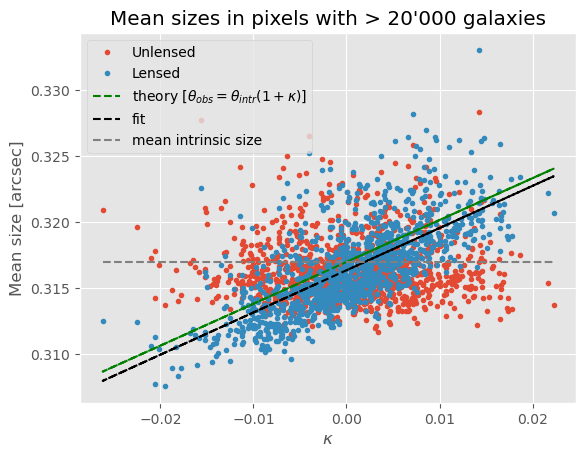

In [95]:
plt.figure()
plt.plot(kappamap_225[pixels], means_unlensed, '.', label='Unlensed')
plt.plot(kappamap_225[pixels], means_lensed, '.', label='Lensed')
plt.plot(kappamap_225[pixels], mean_theory, '--', color='g', label=r'theory $[\theta_{obs}=\theta_{intr}(1+\kappa)]$')
plt.plot(kappamap_225[pixels], m*kappamap_225[pixels]+b, '--', color='black', label='fit')
plt.plot([np.min(kappamap_225[pixels]),np.max(kappamap_225[pixels])],[np.mean(intrinsic_size1000), np.mean(intrinsic_size1000)], '--', color='grey', label='mean intrinsic size')
plt.legend()
plt.xlabel(r'$\kappa$')
plt.ylabel('Mean size [arcsec]')
plt.title('Mean sizes in pixels with > 20\'000 galaxies')
plt.show()

In [96]:
# Welche Pixel müssten noch ein Minuszeichen beim MMD erhalten?

plus_min_mask = (means_lensed - np.mean(observed_size1000_masked)) < 0  # 0 = positive, 1 = negative
plus_min_mask = (-2) * plus_min_mask.astype(int) + 1    # 1 = positive, -1 = negative
plus_min_mask

array([-1, -1, -1, ..., -1, -1, -1], shape=(1145,))

### Now use the MMD (linear kernel)

In [97]:
# SIMPLE IMPLEMENTATION OF MMD FOR DIFFERENT KERNELS ---------------------------------
def compute_mmd(X, Y, kernel):
    """
    Compute Maximum Mean Discrepancy (MMD) between samples X and Y using a provided kernel.
    
    Parameters:
        X: array-like, shape (n_samples_X, n_features)
        Y: array-like, shape (n_samples_Y, n_features)
        kernel: callable, must support signature kernel(X, Y), returns kernel matrix
        
    Returns:
        mmd2: float, MMD^2 value
    """

    X = np.asarray(X)
    Y = np.asarray(Y)
    m = X.shape[0]
    n = Y.shape[0]
    
    K_XX = kernel(X, X)
    K_YY = kernel(Y, Y)
    K_XY = kernel(X, Y)
    
    # Remove diagonal for unbiased estimator
    # np.fill_diagonal(K_XX, 0)
    # np.fill_diagonal(K_YY, 0)
    
    mmd2 = (K_XX.sum() / (m * m)) \
        + (K_YY.sum() / (n * n)) \
        - (2 * K_XY.sum() / (m * n))
    
    return mmd2


def compute_mmd_subsample(X, Y, kernel, size_X=1000, size_Y=1000, n_iter=10, random_state=None):
    """
    Compute MMD between large X and Y by random subsampling.
    Parameters:
        X: array-like (N_X, features), large dataset
        Y: array-like (N_Y, features), large dataset
        kernel: callable kernel (scikit-learn compatible)
        size_X: int, subsample size from X
        size_Y: int, subsample size from Y
        n_iter: int, number of repetitions
        random_state: int or None, reproducibility
    Returns:
        avg_mmd: float, average MMD over n_iter subsamples
        mmd_values: list of individual MMD values
    """
    rng = np.random.default_rng(random_state)
    mmd_values = []
    for i in range(n_iter):
        Xs = rng.choice(X, size_X, replace=False)
        Ys = rng.choice(Y, size_Y, replace=False)
        mmd = compute_mmd(Xs, Ys, kernel)
        mmd_values.append(mmd)
    return np.mean(mmd_values)


Wir lassen mal für alle pixels mit > 20'000 Galaxien die MMD berechnen mit Linear Kernel. Es sollte ein paar Stunden dauern aber wir erwarten die gleichen Ergebnisse wie beim Mean.

In [16]:
"""Don't run! Results already saved to .npy files
mmd2_lensed_linear_kernel = []
Y_lensed = observed_size1000_masked.reshape(-1,1)
for p in pixels:
    mask = (galaxy_pix1000_masked==p)
    if mask.sum()>20000:
        X = observed_size1000_masked[mask].reshape(-1,1)
        mmd2_lensed_linear_kernel.append(compute_mmd_subsample(X, Y_lensed, linear_kernel, 20000,20000,5,42))

mmd2_lensed_linear_kernel= np.array(mmd2_lensed_linear_kernel)
np.save("MMD2_lensed_linear_kernel",mmd2_lensed_linear_kernel)
"""

'Don\'t run! Results already saved to .npy files\nmmd2_lensed_linear_kernel = []\nY_lensed = observed_size1000_masked.reshape(-1,1)\nfor p in pixels:\n    mask = (galaxy_pix1000_masked==p)\n    if mask.sum()>20000:\n        X = observed_size1000_masked[mask].reshape(-1,1)\n        mmd2_lensed_linear_kernel.append(compute_mmd_subsample(X, Y_lensed, linear_kernel, 20000,20000,5,42))\n\nmmd2_lensed_linear_kernel= np.array(mmd2_lensed_linear_kernel)\nnp.save("MMD2_lensed_linear_kernel",mmd2_lensed_linear_kernel)\n'

In [98]:
mmd2_lensed_linear_kernel = np.load("MMD2_lensed_linear_kernel.npy")

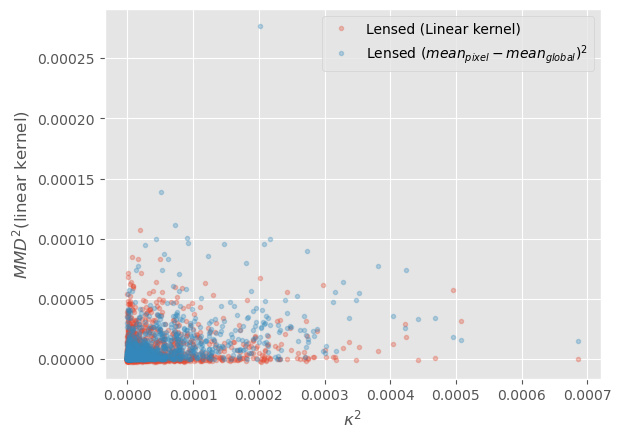

In [99]:
plt.figure()
plt.plot(kappamap_225[pixels]**2, mmd2_lensed_linear_kernel, '.', label='Lensed (Linear kernel)', alpha=0.3)
plt.plot(kappamap_225[pixels]**2, mmd2_lensed_linear_exakt, '.', label=r'Lensed $(mean_{pixel} - mean_{global})^2$', alpha=0.3)
plt.xlabel(r'$\kappa^2$')
plt.ylabel(r'$MMD^2$(linear kernel)')
plt.legend()
plt.show()

MMD² ≈ 1.252e-01 * κ² + 4.134e-06


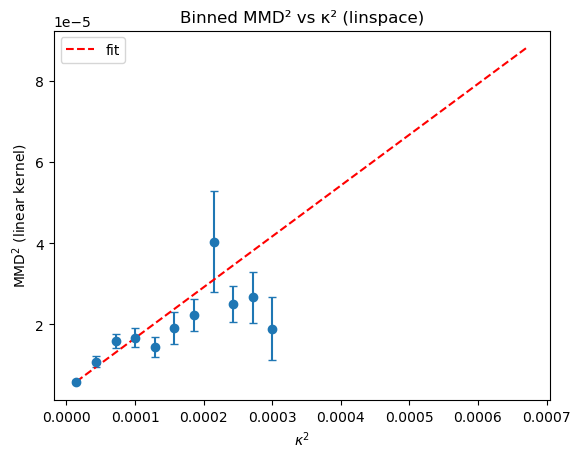

In [115]:
x = kappamap_225[pixels]**2
y = mmd2_lensed_linear_exakt
# y = mmd2_lensed_linear_kernel

n_bins = 24
bins = np.linspace(x.min(), x.max(), n_bins + 1)

# bin indices in [0, n_bins-1]
idx = np.digitize(x, bins) - 1
idx = np.clip(idx, 0, n_bins - 1)

bin_centers = 0.5*(bins[1:] + bins[:-1])

means = np.full(n_bins, np.nan)
stds  = np.full(n_bins, np.nan)
counts = np.zeros(n_bins, dtype=int)

for i in range(n_bins):
    m = (idx == i)
    c = m.sum()
    counts[i] = c
    # print(f"Bin {i}: count = {c}")
    if c >= 1:
        means[i] = y[m].mean()
    if c >= 2:
        stds[i] = y[m].std(ddof=1)

ses = np.where(counts >= 2, stds / np.sqrt(counts), np.nan)

# keep only well-populated bins
min_count = 5
mask = (counts >= min_count) & np.isfinite(means)
xc, yc, sec = bin_centers[mask], means[mask], ses[mask]

# (optional) weighted fit (weights ~ 1/SE^2)
w = np.where(np.isfinite(sec) & (sec > 0), 1.0/sec**2, 1.0)
slope, intercept = np.polyfit(xc, yc, 1, w=w)   # FRAGE : MIT ODER OHNE GEWICHTUNG?
print(f"MMD² ≈ {slope:.3e} * κ² + {intercept:.3e}")

plt.errorbar(xc, yc, yerr=sec, fmt='o', capsize=3)
plt.plot(bin_centers, slope*bin_centers + intercept, 'r--', label='fit')
plt.xlabel(r'$\kappa^2$'); plt.ylabel(r'$\mathrm{MMD}^2$ (linear kernel)')
plt.title('Binned MMD² vs κ² (linspace)')
plt.legend(); plt.show()


In [101]:
# Function that plots the binned plots
from scipy.optimize import curve_fit

def plot_binned_MMD2(kappa_squared= True,y = mmd2_lensed_linear_exakt, binning_method = 'lin'):
    # y = mmd2_lensed_linear_exakt
    # y = mmd2_lensed_list
    if kappa_squared:
        x = kappamap_225[pixels]**2
    else:
        x = kappamap_225[pixels]
    
    n_bins = 24
    if binning_method == 'lin':
        bins = np.linspace(x.min(), x.max(), n_bins + 1)
        title_str = 'linspace'
    elif binning_method == 'log':
        bins = np.logspace(np.log10(x.min() + 1e-8), np.log10(x.max()), n_bins + 1)
        title_str = 'logspace'
    elif binning_method == 'quantile':
        bins = np.quantile(x, np.linspace(0, 1, n_bins + 1))
        bins[0] -= 1e-12  # include min
        title_str = 'quantile'
    else:
        raise ValueError("Invalid binning method. Choose 'lin', 'log', or 'quantile'.") 
    
    idx = np.digitize(x, bins) - 1
    idx = np.clip(idx, 0, n_bins - 1)   

    bin_centers = 0.5*(bins[1:] + bins[:-1])
    means = np.full(n_bins, np.nan)
    stds  = np.full(n_bins, np.nan)
    counts = np.zeros(n_bins, dtype=int)
    for i in range(n_bins):
        m = (idx == i)
        c = m.sum()
        counts[i] = c
        if c >= 1:
            means[i] = y[m].mean()
        if c >= 2:
            stds[i] = y[m].std(ddof=1)
        
    ses = np.where(counts >= 2, stds / np.sqrt(counts), np.nan)

    # keep only well-populated bins
    min_count = 5
    mask = (counts >= min_count) & np.isfinite(means)
    xc, yc, sec = bin_centers[mask], means[mask], ses[mask]

    # (optional) weighted fit (weights ~ 1/SE^2)
    w = np.where(np.isfinite(sec) & (sec > 0), 1.0/sec**2, 1.0)
    if kappa_squared:
        title = rf'Binned MMD² vs $\kappa^2$ ({title_str} bins)'
        slope, intercept = np.polyfit(xc, yc, 1, w=w)
        print(f"MMD² ≈ {slope:.3e} * κ² + {intercept:.3e}")
        plt.plot(bin_centers, slope*bin_centers + intercept, 'r--', label='fit')
    else:
        title = rf'Binned MMD² vs $\kappa$ ({title_str} bins)'
        a2, a1, a0 = np.polyfit(xc, yc, 2, w=w)
        print(f"MMD² ≈ {a2:.3e} * κ² + {a1:.3e} * κ + {a0:.3e}")
        plt.plot(bin_centers, a2*bin_centers**2 + a1*bin_centers + a0, 'r--', label='parabola fit')

        #b=0:
        model_even = lambda kappa, a, c: a * (kappa**2) + c

        popt, pcov = curve_fit(model_even, xc[mask], yc[mask])  # honors sigma as true SE
        a, c = popt
        a_err, c_err = np.sqrt(np.diag(pcov))
        print(f"MMD² ≈ {a:.3e} κ² + {c:.3e}  (± {a_err:.1e}, {c_err:.1e})")
        plt.plot(bin_centers, model_even(bin_centers, a, c), 'g--', label=r'$ax^2 + c$ fit')

    plt.errorbar(xc, yc, yerr=sec, fmt='o', capsize=3)
    plt.xlabel(rf'$\kappa^2$'); plt.ylabel(r'$\mathrm{MMD}^2$ (linear kernel)')
    plt.title(title)
    # plt.xlim(0, 0.0001)
    plt.legend(); plt.show()


MMD² ≈ 1.252e-01 * κ² + 4.134e-06


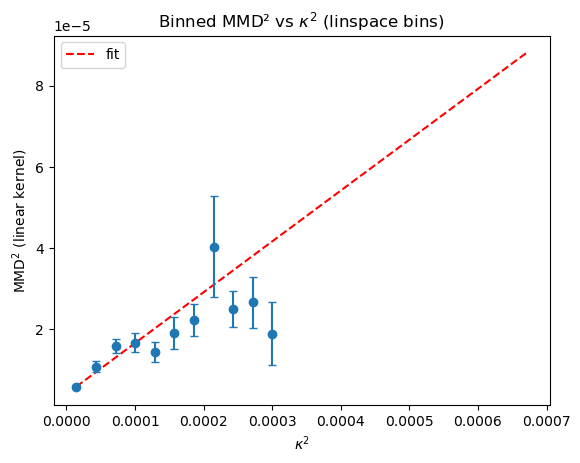

MMD² ≈ -8.213e-03 * κ² + 9.704e-06


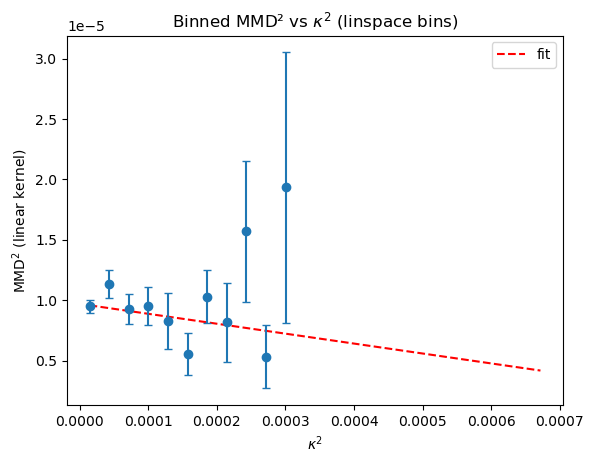

In [114]:
plot_binned_MMD2(kappa_squared=True, y=mmd2_lensed_linear_exakt, binning_method='lin')
plot_binned_MMD2(kappa_squared=True, y=mmd2_lensed_linear_kernel, binning_method='lin')

In [103]:
mmd2_rbf_rff1000 = np.load('mmd2_rbf_rff1000.npy')

In the end, we want to approximate kappa given an MMD. But from the plot above, we can see that we would get a ambiguous kappa, i.e. there are two possible kappas for a given MMD^2. 
What we will do now: We retrieved the sign of each MMD (not MMD^2!) from mean_pix - mean_glob. Now, *we give each MMD the corresponding sign*. Then, we will apply the same binning method as above. 
Apparantely, that is better than getting the sign of the Bin MMDs.

MMD ≈ 3.344e-01 * κ + -1.816e-04


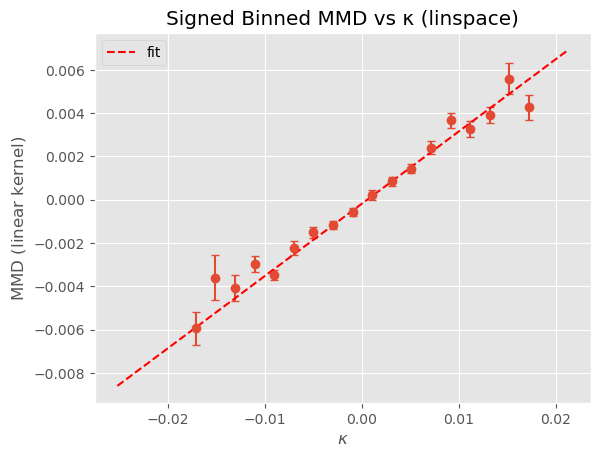

In [104]:
signed_mmd_lensed_linear_exakt = plus_min_mask* np.sqrt(mmd2_lensed_linear_exakt)   # TAKE SQRT OF MMD^2 and assign the sign: +/- MMD

x = kappamap_225[pixels]
y = signed_mmd_lensed_linear_exakt
n_bins = 24
bins = np.linspace(x.min(), x.max(), n_bins + 1)

# bin indices in [0, n_bins-1]
idx = np.digitize(x, bins) - 1
idx = np.clip(idx, 0, n_bins - 1)
bin_centers = 0.5*(bins[1:] + bins[:-1])

means = np.full(n_bins, np.nan)
stds  = np.full(n_bins, np.nan)
counts = np.zeros(n_bins, dtype=int)
for i in range(n_bins):
    m = (idx == i)
    c = m.sum()
    counts[i] = c
    # print(f"Bin {i}: count = {c}")
    if c >= 1:
        means[i] = y[m].mean()
    if c >= 2:
        stds[i] = y[m].std(ddof=1)
    
ses = np.where(counts >= 2, stds / np.sqrt(counts), np.nan)

# keep only well-populated bins
min_count = 5
mask = (counts >= min_count) & np.isfinite(means)
xc, yc, sec = bin_centers[mask], means[mask], ses[mask]

# (optional) weighted fit (weights ~ 1/SE^2)
w = np.where(np.isfinite(sec) & (sec > 0), 1.0/sec**2, 1.0)
slope, intercept = np.polyfit(xc, yc, 1, w=w)
print(f"MMD ≈ {slope:.3e} * κ + {intercept:.3e}")

plt.errorbar(xc, yc, yerr=sec, fmt='o', capsize=3)
plt.plot(bin_centers, slope*bin_centers + intercept, 'r--', label='fit')
plt.xlabel(r'$\kappa$'); plt.ylabel(r'$\mathrm{MMD}$ (linear kernel)')
plt.title('Signed Binned MMD vs κ (linspace)')
plt.legend(); plt.show()


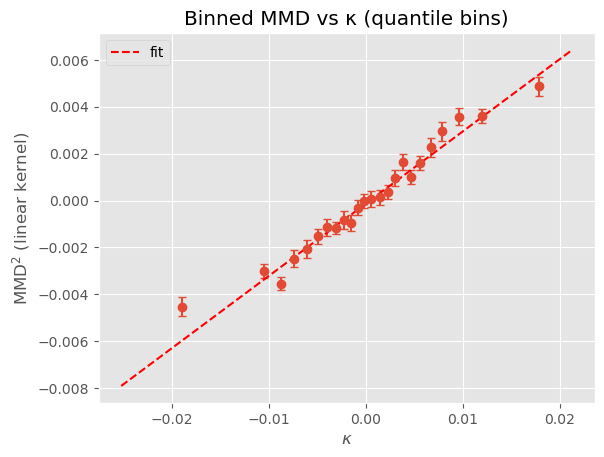

In [105]:
# Same as above but with quantile bins
x = kappamap_225[pixels]
y = signed_mmd_lensed_linear_exakt

n_bins = 24
edges = np.quantile(x, np.linspace(0, 1, n_bins + 1))
edges[0] -= 1e-12  # include min
idx = np.digitize(x, edges) - 1

centers = 0.5*(edges[1:] + edges[:-1])
means  = np.array([y[idx==i].mean() for i in range(n_bins)])
stds   = np.array([y[idx==i].std(ddof=1) for i in range(n_bins)])
counts = np.array([(idx==i).sum() for i in range(n_bins)])
ses    = stds / np.sqrt(np.maximum(counts, 1))

# for i in range(n_bins):
    # print(f"Bin {i}: count = {counts[i]}")
mask = counts >= 20  # optional min bin size
xc, yc, sec = centers[mask], means[mask], ses[mask]
w = 1/np.maximum(sec, 1e-30)**2

slope, intercept = np.polyfit(xc, yc, 1, w=w)
plt.errorbar(xc, yc, yerr=sec, fmt='o', capsize=3)
plt.plot(bin_centers, slope*bin_centers + intercept, 'r--', label='fit')
plt.xlabel(r'$\kappa$'); plt.ylabel(r'$\mathrm{MMD}^2$ (linear kernel)')
plt.title('Binned MMD vs κ (quantile bins)')
# plt.xlim(0, 0.0001)
plt.legend(); plt.show()

In [106]:
def plot_binned_MMD_signed(x, y, binning_method = 'lin', n_bins=24, show=True):
    
    if binning_method == 'lin':
        bins = np.linspace(x.min(), x.max(), n_bins + 1)
        title_str = 'linspace'
    elif binning_method == 'log':
        bins = np.logspace(np.log10(x.min() + 1e-8), np.log10(x.max()), n_bins + 1)
        title_str = 'logspace'
    elif binning_method == 'quantile':
        bins = np.quantile(x, np.linspace(0, 1, n_bins + 1))
        bins[0] -= 1e-12  # include min
        title_str = 'quantile'
    else:
        raise ValueError("Invalid binning method. Choose 'lin', 'log', or 'quantile'.")
    
    idx = np.digitize(x, bins) - 1
    idx = np.clip(idx, 0, n_bins - 1)

    bin_centers = 0.5*(bins[1:] + bins[:-1])

    means = np.full(n_bins, np.nan)
    stds= np.full(n_bins, np.nan)
    counts = np.zeros(n_bins, dtype=int)

    for i in range(n_bins):
        m = (idx == i)
        c = m.sum()
        counts[i] = c
        if c >= 1:
            means[i] = y[m].mean()
            
        if c >= 2:
            stds[i] = y[m].std(ddof=1)


    # keep only well-populated bins
    min_count = 5
    mask = counts >= min_count

    ses = np.where(counts >= 2, stds / np.sqrt(counts), np.nan)
    xc, yc, sec = bin_centers[mask], means[mask], ses[mask]


    # Weighted fit (weights ~ 1/SE^2)
    w = np.where(np.isfinite(sec) & (sec > 0), 1.0/sec**2, 1.0)
    slope, intercept = np.polyfit(xc, yc, 1, w=w)
    print(f"MMD ≈ {slope:.3e} * κ + {intercept:.3e}")
    plt.plot(bin_centers, slope*bin_centers + intercept, 'r--', label='Weighted Fit Exakt MMD')

    plt.errorbar(xc, yc, yerr=sec, fmt='o', capsize=3, label='Exakt MMD $(\mu_{pix} - \mu_{glob})$')
    plt.xlabel(r'$\kappa$'); plt.ylabel(r'$\mathrm{MMD}$ (linear kernel)')


    plt.legend()
    title = rf'Binned signed MMD vs $\kappa$ ({title_str} bins)'
    plt.title(title)
    if show:
        plt.show()
    return  xc, yc, sec

"""
IMPORTANT:
This signed method does not make much sense for MMD, as MMD is inherently non-negative.
1. The sign assignment based on mean differences may not accurately reflect the true nature of MMD.
2. MMD^2 is plotted against kappa, although the ylabel says MMD.
    When plotting MMD^2 vs kappa, we expect a parabolic behavior, which would be seen if we hadn't assigned signs.

3. If we indeed take the sqrt of the MMD^2 values to get MMD and then apply the sign, we would just use the mean difference when using
    a linear kernel, defeating the purpose of MMD.
"""


"\nIMPORTANT:\nThis signed method does not make much sense for MMD, as MMD is inherently non-negative.\n1. The sign assignment based on mean differences may not accurately reflect the true nature of MMD.\n2. MMD^2 is plotted against kappa, although the ylabel says MMD.\n    When plotting MMD^2 vs kappa, we expect a parabolic behavior, which would be seen if we hadn't assigned signs.\n\n3. If we indeed take the sqrt of the MMD^2 values to get MMD and then apply the sign, we would just use the mean difference when using\n    a linear kernel, defeating the purpose of MMD.\n"

In [107]:
"""
To take the square root of the MMD^2 values, they have to be non-negative.
However, due to numerical inaccuracies, some MMD^2 values of mmd2_lensed_linear_kernel might be slightly negative.
Here, we resolve this problem by setting negative MMD^2 values to zero before taking the square root.
"""
signed_mmd_lensed_linear_kernel = plus_min_mask*np.sqrt(np.maximum(mmd2_lensed_linear_kernel, 0))

MMD ≈ 3.083e-01 * κ + -1.354e-04


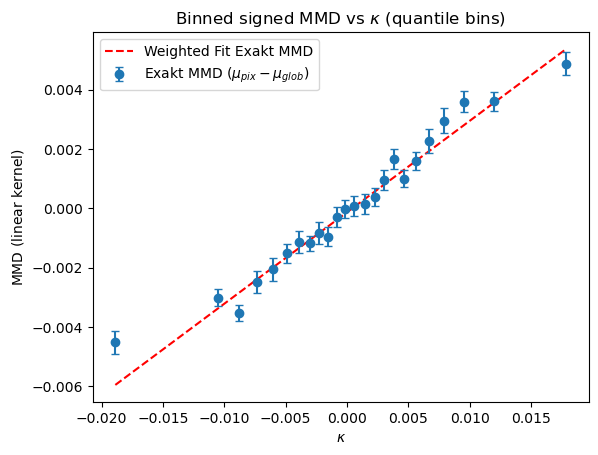

MMD ≈ 1.963e-01 * κ + -4.350e-04


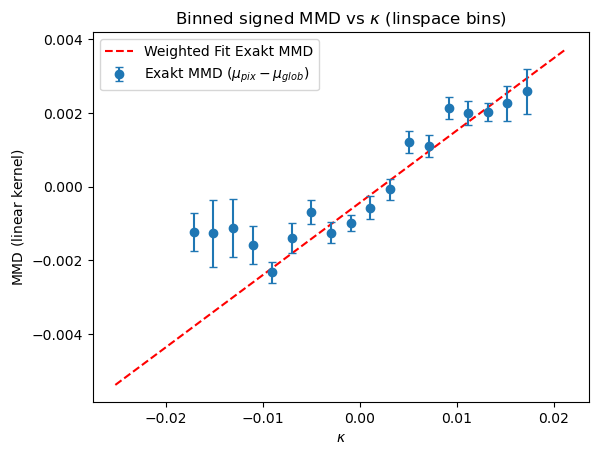

In [116]:
_,_,_ = plot_binned_MMD_signed(kappamap_225[pixels], signed_mmd_lensed_linear_exakt, binning_method='quantile')
_,_,_ =plot_binned_MMD_signed(kappamap_225[pixels], signed_mmd_lensed_linear_kernel, binning_method='lin')

### Noise Level with exakt linear Kernel
Get noise level:
We get many MMDs between random samples, take their mean and std and plot it as a horizontal band. If our signal is outside of this band, we know it is a real singal.

In [117]:
mmd2_noise = []
rng = np.random.default_rng(42)

size = 20_000  # match your per-pixel (or subsample) size
for _ in range(15000):
    Xs = rng.choice(observed_size1000_masked, size=size, replace=False)
    Ys = rng.choice(observed_size1000_masked, size=size, replace=False)
    mmd2_noise.append( (Xs.mean() - Ys.mean())**2 )

mmd2_noise = np.array(mmd2_noise)
noise_mean = mmd2_noise.mean()
noise_std  = mmd2_noise.std(ddof=1)



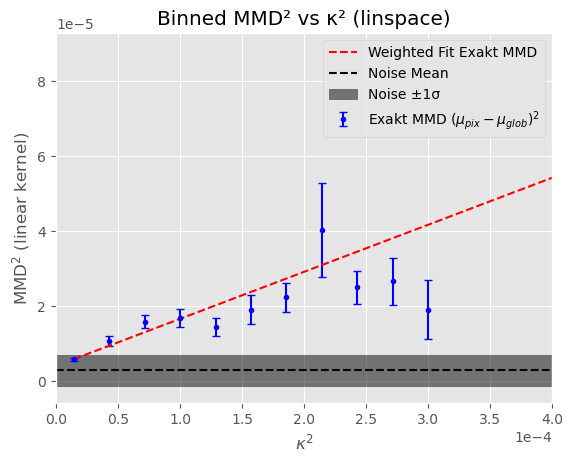

In [ ]:
plt.style.use('ggplot')
from matplotlib.ticker import ScalarFormatter

plt.errorbar(xc, yc, yerr=sec, fmt='.', capsize=3, label=r'Exakt MMD $(\mu_{pix} - \mu_{glob})^2$', color='blue')
plt.plot(bin_centers, slope*bin_centers + intercept, 'r--', label='Weighted Fit Exakt MMD')
plt.axhline(noise_mean, color='black', linestyle='--', label='Noise Mean')
plt.fill_between([0,0.0007], 
                 noise_mean - noise_std, 
                 noise_mean + noise_std,
                 color='black', alpha=0.5, label='Noise ±1σ')
plt.xlim(0, 0.0004)
plt.legend()
plt.xlabel(r'$\kappa^2$'); plt.ylabel(r'$\mathrm{MMD}^2$ (linear kernel)')
plt.title('Binned MMD² vs κ² (linspace)')

ax = plt.gca()
fmt = ScalarFormatter(useMathText=True)
fmt.set_powerlimits((0, 0))         # always use scientific notation
ax.xaxis.set_major_formatter(fmt)
ax.ticklabel_format(axis='x', style='sci', scilimits=(0, 0), useMathText=False)
ax.ticklabel_format(useOffset=True) # keep the scientific scale as an offset text
plt.show()

### MMD plots using Random Fourier Features:

0.0002766573331355907 0.0011546632213776248


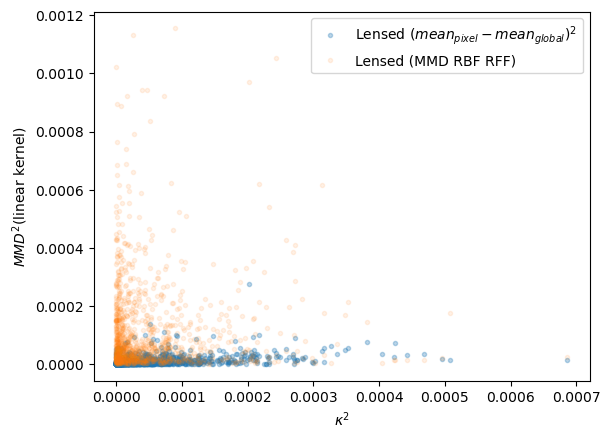

In [78]:
mmd2_rbf_rff1000= np.load('mmd2_rbf_rff1000.npy')


plt.plot(kappamap_225[pixels]**2, mmd2_lensed_linear_exakt, '.', label=r'Lensed $(mean_{pixel} - mean_{global})^2$', alpha=0.3)
plt.plot(kappamap_225[pixels]**2, mmd2_rbf_rff1000, '.', label='Lensed (MMD RBF RFF)', alpha=0.1)
plt.legend()
plt.xlabel(r'$\kappa^2$')
plt.ylabel(r'$MMD^2$(linear kernel)')
print(np.max(mmd2_lensed_linear_exakt), np.max(mmd2_rbf_rff1000))

MMD² ≈ -4.136e-01 * κ² + 1.223e-04


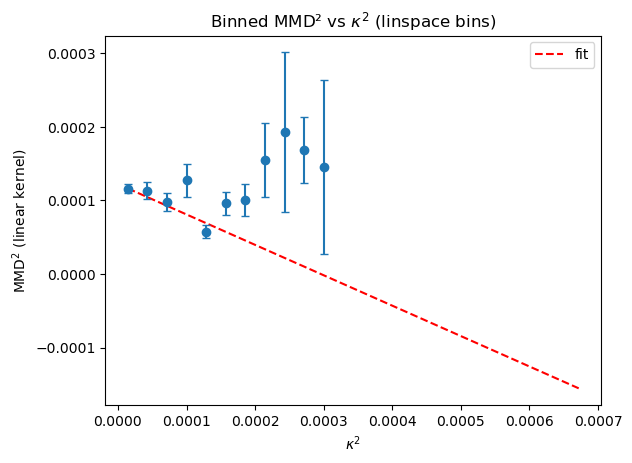

In [79]:
plot_binned_MMD2(kappa_squared=True, y=mmd2_rbf_rff1000, binning_method='lin')

### Try again MMD using MC on large data set 
Check how long it would take

In [112]:
def unbiased_Exx(X,sigma):
    """
    Compute E[k(X,X)] exactly without diagonal terms (i.e. unbiased)
    """
    inv2s2= 1.0 /(2.0*sigma**2)
    D2 = np.square(X[:, None,:] - X[None, :, :]).sum(axis=2)
    np.fill_diagonal(D2,np.nan)
    return np.nanmean(np.exp(-inv2s2*D2))

def MC_Eyy(Y, sigma, n_pairs=200_000, rng=None):
    """
    Compute E[k(Y,Y)] by sampling many distinct pairs from Y. (Monte Carlo)
    """
    rng = np.random.default_rng() if rng is None else rng
    n = Y.shape[0]
    i = rng.integers(0, n, size=n_pairs)
    j = rng.integers(0, n-1, size=n_pairs)
    j = j + (j >= i)  # ensure j != i
    inv2s2 = 1.0 / (2.0 * sigma * sigma)
    D2 = np.square(Y[i] - Y[j]).sum(axis=1)
    return np.mean(np.exp(-inv2s2 * D2))

def MC_Exy(X, Y, sigma, n_pairs=1_000_000, rng=None):
    rng = np.random.default_rng() if rng is None else rng
    X = np.atleast_2d(X); Y = np.atleast_2d(Y)
    m, n = X.shape[0], Y.shape[0]
    ix = rng.integers(0, m, size=n_pairs)
    jy = rng.integers(0, n, size=n_pairs)
    diff = X[ix] - Y[jy]
    inv2s2 = 1.0 / (2.0 * sigma * sigma)
    d2 = np.einsum('nd,nd->n', diff, diff)
    return float(np.mean(np.exp(-inv2s2 * d2)))


def mean_rbf_xy(X, Y, sigma, block=500_000):
    """
    Compute E[k(X,Y)] exactly without storing full Gram matrix (uses rbf kernel)
    """
    inv2s2 = 1.0 / (2.0 * sigma * sigma)
    m = X.shape[0]; n = Y.shape[0]
    total = 0.0; count = 0
    for s in range(0, n, block):
        Yb = Y[s:s+block]
        X2 = np.sum(X**2, axis=1, keepdims=True)      # (m,1)
        Y2 = np.sum(Yb**2, axis=1, keepdims=True).T   # (1,|b|)
        D2 = X2 + Y2 - 2 * X @ Yb.T
        K = np.exp(-inv2s2 * D2)
        total += K.sum(); count += K.size
    return total / count

#Compute the MMD using the above 4 functions
def mmd2_biased_fast(X, Y, sigma, n_pairs_yy=200_000):
    """
    Suitable for small X and large Y. If X becomes large too using a different galaxy catalogue,
    consider changing this function to compute E_XX also using MC.
    """
    exx = unbiased_Exx(X, sigma) if len(X)<5000 else MC_Eyy(X,sigma,n_pairs_yy)                 # tiny (m~100)
    exy = mean_rbf_xy(X, Y, sigma)               # exact mean, blockwise
    eyy = MC_Eyy(Y, sigma, n_pairs_yy)           # Monte-Carlo
    return exx + eyy - 2.0 * exy

#Helperfunction to find a good value of sigma for the rbf kernel using median heuristic approach
def sigma_median(X, Y, max_y=5000, rng=None, eps=1e-12):
    rng = np.random.default_rng() if rng is None else rng
    Yc = Y if Y.shape[0] <= max_y else rng.choice(Y.ravel(), size=max_y, replace=False).reshape(-1,1)
    Z = np.vstack([X, Yc])
    D2 = (Z[:,None,:] - Z[None,:,:])**2
    tri = D2[np.triu_indices_from(D2[:,:,0], k=1)]
    med = np.median(tri[tri > 0])
    return float(np.sqrt(max(med, eps)))

#Same Helperfunction as above but for very large Y and X is a subsample of Y.
def sigma_median_pairs(Y, n_pairs=1_000_000, rng=None, eps=1e-12):
    """
    Global RBF bandwidth σ by the median heuristic:
      σ^2 ≈ median( ||y_i - y_j||^2 ) over randomly sampled i≠j pairs from Y.
    Works for shape (n,) or (n,d). O(n_pairs·d) time, O(n_pairs) memory.
    """
    rng = np.random.default_rng() if rng is None else rng
    Y = np.asarray(Y)
    if Y.ndim == 1:
        Y = Y[:, None]  # (n,1)

    n = Y.shape[0]
    i = rng.integers(0, n, size=n_pairs)
    j = rng.integers(0, n - 1, size=n_pairs)
    j = j + (j >= i)  # ensure i != j

    diffs = Y[i] - Y[j]                 # (n_pairs, d)
    d2 = np.einsum('nd,nd->n', diffs, diffs)  # squared norms
    med = np.median(d2[d2 > 0]) if np.any(d2 > 0) else 0.0
    return float(np.sqrt(max(med, eps)))      # returns σ (not σ^2)


def get_MMDs(size_distr, galaxy_pixels, n_gal=100, 
             sigma= None, n_pairs_yy = 200_000,n_pairs_xy=1_000_000, rng=None):
    """
    Input:
    size_distr: Array with the sizes of all galaxies (preferably converted into arcsec). 
                -> catalogue['r50']*pixscale
    galaxy_pix: Array with the number of the pixel at which each galaxy is located.
    n_gal:  Threshold number for which the MMD is computed for a pixel. 
            If there are not enough galaxies in the pixel, the MMD will not be computed.

    Output:
    MMDs: np.array of the MMDs between the galaxy size distribution in a pixel and the whole distr
    pixels: np.array of the pixel numbers for which the MMD was computed. Can later be used to get 
            the corresponding kappa value for these pixels.
    """
    rng = np.random.default_rng() if rng is None else rng
    Y= size_distr.reshape(-1,1) # Sizes of all galaxies in the right format to work with sklearn

    # #Fix sigma globally if not provided
    # if sigma is None:
    #     sigma = sigma_median_pairs(Y,rng=rng)

    #Precompute E[k(Y,Y)] once (using MC)
    Eyy = MC_Eyy(Y,sigma, n_pairs=n_pairs_yy, rng=rng)

    unique_pixels = np.unique(galaxy_pixels)
    mmd_list =[]
    pix_list = []
    # n_pix= hp.nside2npix(nside) # Number of pixels

    for pixel in unique_pixels:
        mask = (galaxy_pixels == pixel)
        m = int(mask.sum())
        if m < max(n_gal, 2):
            continue

        X = size_distr[mask].reshape(-1,1)   # Size of all galaxies in the pixel nr. {pixel}
        
        #E[k(X,X)] - exact for small X, else MC
        if m < 3000:
            Exx = unbiased_Exx(X, sigma)
        else: 
            Exx = MC_Eyy(X,sigma, n_pairs=min(200_000, m*(m-1)), rng=rng)


        # E[k(X,Y)] – exact mean via blocks
        Exy = MC_Exy(X,Y,sigma, n_pairs=n_pairs_xy ,rng=rng)

        mmd2 = Exx + Eyy -2.0*Exy
        # mmd = np.sqrt(np.maximum(mmd2, 0.0))
        pix_list.append(pixel)   # List of the pixels for which MMD was computed, later used to get the right kappa values
        mmd_list.append(mmd2)


    return np.array(mmd_list), np.array(pix_list)


In [115]:
mmd2_biased_fast(X1,X1, sigma=1.0)

np.float32(-0.0002771616)

In [171]:
sigma = sigma_median_pairs(intrinsic_size1000_masked, 2_000_000)
mmds_unlensed, pixels_unlensed = get_MMDs(intrinsic_size1000_masked, galaxy_pix1000_masked, n_gal=20000, sigma=sigma, n_pairs_yy=20_000_000, n_pairs_xy=100_000_000)
mmds_lensed, pixels_lensed = get_MMDs(observed_size1000_masked, galaxy_pix1000_masked, n_gal=20000, sigma=sigma, n_pairs_yy=20_000_000, n_pairs_xy=100_000_000)

KeyboardInterrupt: 

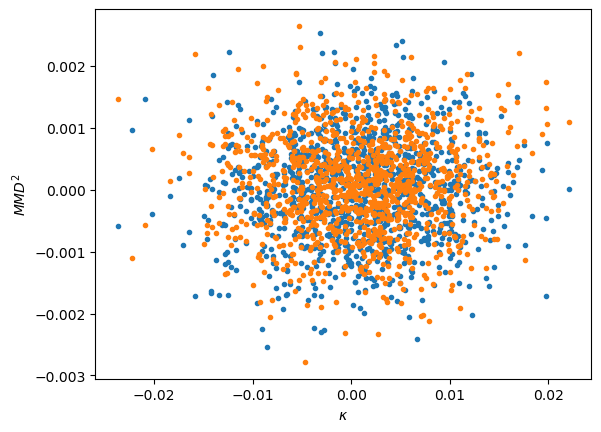

In [139]:
plt.figure()
plt.plot(kappamap_225[pixels_unlensed], mmds_unlensed, '.', label='unlensed')
plt.plot(kappamap_225[pixels_lensed], mmds_lensed, '.', label='lensed')
plt.xlabel(r'$\kappa$')
plt.ylabel(r'$MMD^2$')
plt.show()

### RBF kernel


In [154]:
# Load RBF Data from previous computations
mmd2_lensed_rbf_MC1000_batch1 = np.load(f"mmd2_lensed_rbf/mmd2_lensed_rbf_MC1000_batch1.npy")
mmd2_lensed_rbf_MC1000_batch2 = np.load(f"mmd2_lensed_rbf/mmd2_lensed_rbf_MC1000_batch2.npy")
mmd2_lensed_rbf_MC1000_batch3 = np.load(f"mmd2_lensed_rbf/mmd2_lensed_rbf_MC1000_batch3.npy")
mmd2_lensed_rbf_MC1000_batch4 = np.load(f"mmd2_lensed_rbf/mmd2_lensed_rbf_MC1000_batch4.npy")
mmd2_lensed_rbf_MC1000_batch5 = np.load(f"mmd2_lensed_rbf/mmd2_lensed_rbf_MC1000_batch5.npy")
mmd2_lensed_rbf_MC1000_batch6 = np.load(f"mmd2_lensed_rbf/mmd2_lensed_rbf_MC1000_batch6.npy")
mmd2_lensed_rbf_MC1000_batch7 = np.load(f"mmd2_lensed_rbf/mmd2_lensed_rbf_MC1000_batch7.npy")
mmd2_lensed_rbf_MC1000_batch8 = np.load(f"mmd2_lensed_rbf/mmd2_lensed_rbf_MC1000_batch8.npy")
mmd2_lensed_rbf_MC1000_batch9 = np.load(f"mmd2_lensed_rbf/mmd2_lensed_rbf_MC1000_batch9.npy")
mmd2_lensed_rbf_MC1000_batch10 = np.load(f"mmd2_lensed_rbf/mmd2_lensed_rbf_MC1000_batch10.npy")

In [166]:
mmd2_lensed_rbf_MC1000 = np.concatenate((mmd2_lensed_rbf_MC1000_batch1, mmd2_lensed_rbf_MC1000_batch2,
                                         mmd2_lensed_rbf_MC1000_batch3, mmd2_lensed_rbf_MC1000_batch4,
                                         mmd2_lensed_rbf_MC1000_batch5, mmd2_lensed_rbf_MC1000_batch6,
                                         mmd2_lensed_rbf_MC1000_batch7, mmd2_lensed_rbf_MC1000_batch8,
                                         mmd2_lensed_rbf_MC1000_batch9, mmd2_lensed_rbf_MC1000_batch10), axis=0)

mmd2_rbf_rff1000 = np.load('mmd2_rbf_rff1000.npy')

COUNTS: [634 179 113  64  39  27  24  22  10  13   5   4   2   1   3   1   1   2
   0   0   0   0   0   1]
MMD² ≈ -1.709e-02 * κ² + 1.152e-04


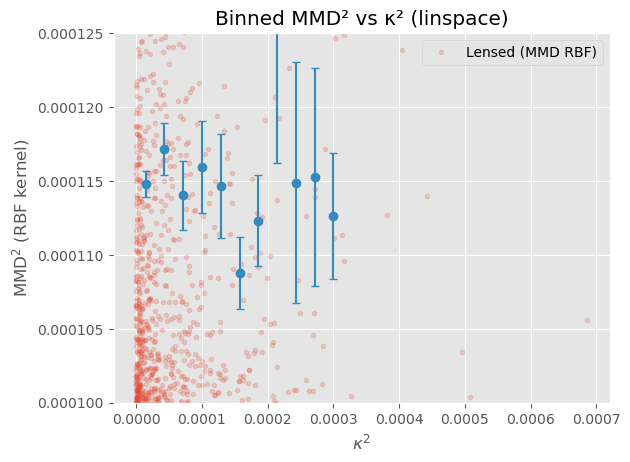

In [177]:
n_bins = 24
bins = np.linspace(np.min(kappamap_225[pixels]**2), np.max(kappamap_225[pixels]**2), n_bins + 1)

# bin indices in [0, n_bins-1]
idx = np.digitize(kappamap_225[pixels]**2, bins) - 1
idx = np.clip(idx, 0, n_bins - 1)

bin_centers = 0.5*(bins[1:] + bins[:-1])

means = np.full(n_bins, np.nan)
stds  = np.full(n_bins, np.nan)
counts = np.zeros(n_bins, dtype=int)

for i in range(n_bins):
    m = (idx == i)
    c = m.sum()
    counts[i] = c
    # print(f"Bin {i}: count = {c}")
    if c >= 1:
        means[i] = mmd2_lensed_rbf_MC1000[m].mean()
    if c >= 2:
        stds[i] = mmd2_lensed_rbf_MC1000[m].std(ddof=1)

print("COUNTS:", counts)
ses = np.where(counts >= 2, stds / np.sqrt(counts), np.nan)

# keep only well-populated bins
min_count = 5
mask = (counts >= min_count) & np.isfinite(means)
xc, yc, sec = bin_centers[mask], means[mask], ses[mask]

# (optional) weighted fit (weights ~ 1/SE^2)
w = np.where(np.isfinite(sec) & (sec > 0), 1.0/sec**2, 1.0)
slope, intercept = np.polyfit(xc, yc, 1, w=w)   # FRAGE : MIT ODER OHNE GEWICHTUNG?
print(f"MMD² ≈ {slope:.3e} * κ² + {intercept:.3e}")

plt.plot(kappamap_225[pixels]**2, mmd2_lensed_rbf_MC1000, '.', label='Lensed (MMD RBF)', alpha=0.2)

plt.errorbar(xc, yc, yerr=sec, fmt='o', capsize=3)
# plt.plot(bin_centers, slope*bin_centers + intercept, 'r--', label='fit')
plt.xlabel(r'$\kappa^2$'); plt.ylabel(r'$\mathrm{MMD}^2$ (RBF kernel)')
plt.title('Binned MMD² vs κ² (linspace)')
plt.ylim(0.0001, 0.000125)
plt.legend(); plt.show()

### Finer Convergence map
Now we want to apply a finer/smoother convergence map to the galaxies. We will then compute the MMD of the coarser pixels, such that each bigger pixel represents a neighbourhood of galaxies with slightly different kappas.

In [181]:
# Create a smoother convergence map.
# From now on, we only use the big catalogue
nside_fine = 1024

kappamap_fine = hp.synfast( cl_kappa_225, nside_fine)
print(hp.nside2npix(nside_fine))

12582912


In [182]:
# Convert galaxy coordinates to pixel numbers in the finer map
gal_pix_fine = hp.ang2pix(nside_fine, catalogue1000['ra'], catalogue1000['dec'], lonlat=True)
gal_pix_fine_unique, gal_pix_fine_counts = np.unique(gal_pix_fine, return_counts=True)

print("Galaxy pixels:",gal_pix_fine, "   Length of Galaxy pixels(should match nr. of galaxies):", len(gal_pix_fine))
print("Number of unique pixels with galaxies:", len(gal_pix_fine_unique))
print("Max number of galaxies in a pixel:", np.max(gal_pix_fine_counts))
print("Min number of galaxies in a pixel:", np.min(gal_pix_fine_counts))
print("Mean number of galaxies in a pixel:", np.mean(gal_pix_fine_counts))
print("Number of pixels with > 20'000 galaxies:", np.sum(gal_pix_fine_counts >= 20000))
print('-'*30)


# Compute observed sizes for all galaxies using the finer kappa map
observed_size_fine = intrinsic_size1000 * (1.0 + kappamap_fine[gal_pix_fine])


Galaxy pixels: [4372481 4368384 4376574 ... 8214525 8210426 8218620]    Length of Galaxy pixels(should match nr. of galaxies): 31574550
Number of unique pixels with galaxies: 302660
Max number of galaxies in a pixel: 157
Min number of galaxies in a pixel: 1
Mean number of galaxies in a pixel: 104.32349831494086
Number of pixels with > 20'000 galaxies: 0
------------------------------


In [ ]:
# Compute the MMDs for each bigger/coarser pixel but the new observed sizes.
# Compute also the averaged kappa values for each bigger pixel.



### Finer Convergence Map


In [185]:
mmd2_lensed_rbf_fine_batch1 = np.load(f"mmd2_lensed_rbf_fine/mmd2_lensed_rbf_fine_batch_1.npy")
mmd2_lensed_rbf_fine_batch2 = np.load(f"mmd2_lensed_rbf_fine/mmd2_lensed_rbf_fine_batch_2.npy")
mmd2_lensed_rbf_fine_batch3 = np.load(f"mmd2_lensed_rbf_fine/mmd2_lensed_rbf_fine_batch_3.npy")
mmd2_lensed_rbf_fine_batch4 = np.load(f"mmd2_lensed_rbf_fine/mmd2_lensed_rbf_fine_batch_4.npy")
mmd2_lensed_rbf_fine_batch5 = np.load(f"mmd2_lensed_rbf_fine/mmd2_lensed_rbf_fine_batch_5.npy")
mmd2_lensed_rbf_fine_batch6 = np.load(f"mmd2_lensed_rbf_fine/mmd2_lensed_rbf_fine_batch_6.npy")
mmd2_lensed_rbf_fine_batch7 = np.load(f"mmd2_lensed_rbf_fine/mmd2_lensed_rbf_fine_batch_7.npy")
mmd2_lensed_rbf_fine_batch8 = np.load(f"mmd2_lensed_rbf_fine/mmd2_lensed_rbf_fine_batch_8.npy")
mmd2_lensed_rbf_fine_batch9 = np.load(f"mmd2_lensed_rbf_fine/mmd2_lensed_rbf_fine_batch_9.npy")
mmd2_lensed_rbf_fine_batch10 = np.load(f"mmd2_lensed_rbf_fine/mmd2_lensed_rbf_fine_batch_10.npy")

In [205]:
kappamap_avg_fine = np.load('kappa_avg_fine.npy')
mmd2_rbf_noise_fine = np.load('mmd2_rbf_noise.npy')
mmd2_rbf_noise_mean_fine = np.mean(mmd2_rbf_noise_fine)
mmd2_rbf_noise_std_fine = np.std(mmd2_rbf_noise_fine, ddof=1)

mmd2_lensed_rbf_fine = np.concatenate((mmd2_lensed_rbf_fine_batch1, mmd2_lensed_rbf_fine_batch2,
                                       mmd2_lensed_rbf_fine_batch3, mmd2_lensed_rbf_fine_batch4,
                                       mmd2_lensed_rbf_fine_batch5, mmd2_lensed_rbf_fine_batch6,
                                       mmd2_lensed_rbf_fine_batch7, mmd2_lensed_rbf_fine_batch8,
                                       mmd2_lensed_rbf_fine_batch9, mmd2_lensed_rbf_fine_batch10), axis=0)

mask_20k_gals = galaxy_pix1000_counts >= 20000  # pixels with at least 20k galaxies
kappamap_avg_fine = kappamap_avg_fine[mask_20k_gals]


COUNTS: [559 187 110  75  49  43  28  16  16  17  11  10   5   5   1   2   0   5
   3   0   0   1   0   2]
MMD² ≈ 1.383e-01 * κ² + 1.042e-04


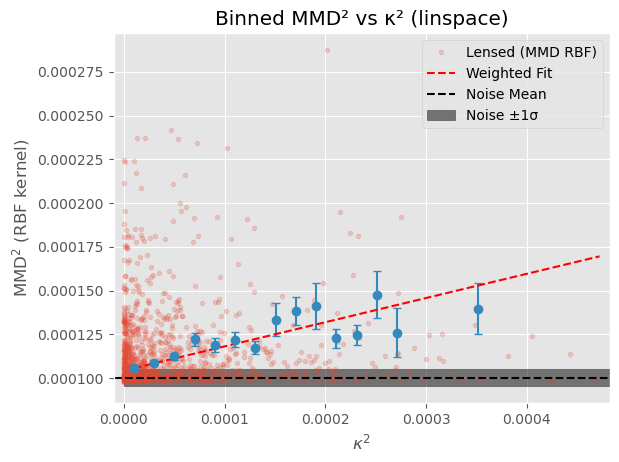

In [208]:
n_bins = 24
bins = np.linspace(np.min(kappamap_avg_fine**2), np.max(kappamap_avg_fine**2), n_bins + 1)

# bin indices in [0, n_bins-1]
idx = np.digitize(kappamap_avg_fine**2, bins) - 1
idx = np.clip(idx, 0, n_bins - 1)

bin_centers = 0.5*(bins[1:] + bins[:-1])

means = np.full(n_bins, np.nan)
stds  = np.full(n_bins, np.nan)
counts = np.zeros(n_bins, dtype=int)

for i in range(n_bins):
    m = (idx == i)
    c = m.sum()
    counts[i] = c
    # print(f"Bin {i}: count = {c}")
    if c >= 1:
        means[i] = mmd2_lensed_rbf_fine[m].mean()
    if c >= 2:
        stds[i] = mmd2_lensed_rbf_fine[m].std(ddof=1)

print("COUNTS:", counts)
ses = np.where(counts >= 2, stds / np.sqrt(counts), np.nan)

# keep only well-populated bins
min_count = 5
mask = (counts >= min_count) & np.isfinite(means)
xc, yc, sec = bin_centers[mask], means[mask], ses[mask]

# (optional) weighted fit (weights ~ 1/SE^2)
w = np.where(np.isfinite(sec) & (sec > 0), 1.0/sec**2, 1.0)
slope, intercept = np.polyfit(xc, yc, 1, w=w)   # FRAGE : MIT ODER OHNE GEWICHTUNG?
print(f"MMD² ≈ {slope:.3e} * κ² + {intercept:.3e}")

plt.plot(kappamap_225[pixels]**2, mmd2_lensed_rbf_MC1000, '.', label='Lensed (MMD RBF)', alpha=0.2)

plt.errorbar(xc, yc, yerr=sec, fmt='o', capsize=3)
plt.plot(bin_centers, slope*bin_centers + intercept, 'r--', label='Weighted Fit')
plt.xlabel(r'$\kappa^2$'); plt.ylabel(r'$\mathrm{MMD}^2$ (RBF kernel)')
plt.axhline(mmd2_rbf_noise_mean_fine, color='black', linestyle='--', label='Noise Mean')
plt.fill_between([0,0.0007], 
                 mmd2_rbf_noise_mean_fine - mmd2_rbf_noise_std_fine, 
                 mmd2_rbf_noise_mean_fine + mmd2_rbf_noise_std_fine,
                 color='black', alpha=0.5, label='Noise ±1σ')
plt.title('Binned MMD² vs κ² (linspace)')
# plt.ylim(0.0001, 0.000125)
plt.xlim(np.min(bins)-1e-5, np.max(bins))
plt.legend(); plt.show()